In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append('/u/e/jb2854/Mergers_Project')
from illustris_python import illustris_python as il
sys.path.append('/u/e/jb2854/Mergers_Project')
import tools

basePath = '/x/Physics/AstroPhysics/Shared-New/DATA/IllustrisTNG/TNG100-1/output'

In [2]:
def mergerInfo(tree, minMassRatio=1e-10, massPartType='stars', index=0):
    """ Based off numMergers function to identify the mergers, this function returns the two progenitor masses (default stellar) and the snapshot in which merging occured"""
    # verify the input sub-tree has the required fields
    reqFields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassType','SnapNum', 'DescendantID']

    if not set(reqFields).issubset(tree.keys()):
        raise Exception('Error: Input tree needs to have loaded fields: '+', '.join(reqFields))

    numMergers   = 0
    mergerProgenitors = []
    invMassRatio = 1.0 / minMassRatio

    # walk back main progenitor branch
    rootID = tree['SubhaloID'][index]
    fpID   = tree['FirstProgenitorID'][index]

    while fpID != -1:
        fpIndex = index + (fpID - rootID)

        # explore breadth
        npID = tree['NextProgenitorID'][fpIndex]

        while npID != -1:
            npIndex = index + (npID - rootID)
            npMassMax  = il.sublink.maxPastMassSnapNum(tree, npIndex, massPartType)
            npMass = npMassMax[0]
            npMassMaxSnap = npMassMax[1]
            
            fpMassIndex = fpIndex
            
            while (npMassMaxSnap != tree['SnapNum'][fpMassIndex]):
                fpMassIndex = fpMassIndex + 1
            
            
            fpMass = tree['SubhaloMassType'][fpMassIndex, il.util.partTypeNum(massPartType)]

            # count if both masses are non-zero, and ratio exceeds threshold
            if fpMass > 1e-2 and npMass > 1e-2:
                ratio = npMass / fpMass
                
                if ratio > 1:
                    ratio = 1/ratio

                if ratio >= minMassRatio:
                    
                    #mergerProgenitors.append([ratio, npMassMaxSnap, tree['SnapNum'][fpMassIndex], tree['SnapNum'][npIndex], tree['SnapNum'][fpIndex], tree['SubfindID'][fpIndex], tree['SubfindID'][npIndex]])
                    fpMassNow = tree['SubhaloMassType'][fpIndex, il.util.partTypeNum(massPartType)]
                    npMassNow = tree['SubhaloMassType'][npIndex, il.util.partTypeNum(massPartType)]
                    
                    mergerProgenitors.append([ratio, npMassMaxSnap, npMass, fpMass, npMassNow, fpMassNow, tree['SnapNum'][fpIndex], tree['SubfindID'][fpIndex], tree['SubfindID'][npIndex], tree['SubfindID'][fpIndex-1]])
                    
                    #if (npMassMaxSnap - tree['SnapNum'][fpIndex + tree['SnapNum'][npIndex] - npMassMaxSnap] == -1):
                     #   mergerProgenitors.append([ratio, npMassMaxSnap - tree['SnapNum'][npIndex], tree['SnapNum'][fpIndex + tree['SnapNum'][npIndex] - npMassMaxSnap]])
                    
            npID = tree['NextProgenitorID'][npIndex]

        fpID = tree['FirstProgenitorID'][fpIndex]

    return mergerProgenitors

In [3]:
# [Mass ratio, Mass ratio sublink method]

fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType','SnapNum', 'DescendantID', 'SubfindID']
groupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])

subhalo_data = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloFlag', 'SubhaloMass', 'SubhaloGrNr'])
subhalo_flag = subhalo_data['SubhaloFlag']
good_cen_idx = np.intersect1d(groupFirstSub, np.where(subhalo_flag==1)[0])
good_idx = subhalo_flag == 1   

In [11]:
#print(good_cen_idx[0])
#print(np.where(good_idx == True)[0][0])

mass_ratios = np.zeros([0,10])
min_ratio = 1/10
for i in range(0, 1000, 1):
    tree = il.sublink.loadTree(basePath,99,good_cen_idx[i],fields=fields)

    if (mergerInfo(tree, min_ratio)):
        mass_ratios = np.vstack((mass_ratios, mergerInfo(tree, min_ratio)))
        

In [ ]:
mass_ratios_all = np.zeros([0,7])
min_ratio = 1/10
for i in range(0, 1000, 1):
    print()
    tree = il.sublink.loadTree(basePath,99,good_idx[i],fields=fields)

    if (mergerInfo(tree, min_ratio)):
        mass_ratios_all = np.vstack((mass_ratios_all, mergerInfo(tree, min_ratio)))

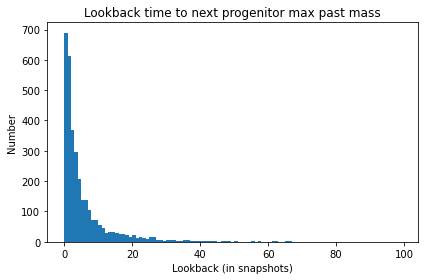

In [14]:
SnapDiff = mass_ratios[:,6] - mass_ratios[:,1]
plt.hist(SnapDiff, bins = np.linspace(0, 99, 100))
plt.title('Lookback time to next progenitor max past mass')
plt.xlabel('Lookback (in snapshots)')
plt.ylabel('Number')
plt.tight_layout()

#plt.scatter(mass_ratios[:,1] - mass_ratios[:,2], SnapDiff)


[15. 19. 10. ...  6.  9.  1.]
[[-1.00000000e+00  6.45997941e-01  6.45997941e-01  2.65566468e-01
   5.20000000e+01  3.49089000e+05]
 [-1.00000000e+00  8.26934040e-01  8.26934040e-01  5.23691118e-01
   2.10000000e+01  1.80070000e+04]
 [-1.00000000e+00  4.44048762e-01  4.44048762e-01  3.63792479e-01
   2.60000000e+01  1.01268000e+05]
 ...
 [ 6.20000000e+01  3.42316704e+01  6.09953642e-01  6.37531929e+01
   9.70000000e+01  1.21169000e+05]
 [ 6.50000000e+01  3.06042641e-01  1.34191985e-04  1.33802366e+01
   9.70000000e+01  2.92513000e+05]
 [ 6.60000000e+01  2.78222775e+00  1.24591950e-03  1.20244207e+01
   9.60000000e+01  3.05149000e+05]]


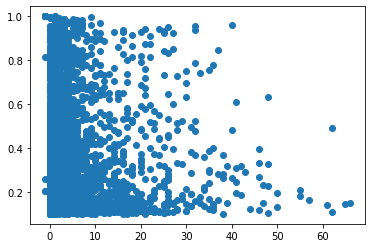

In [12]:
SnapDiff = np.zeros([0,6])

for i in range(len(mass_ratios)):
    SnapDiff = np.vstack((SnapDiff, [mass_ratios[i,6] - mass_ratios[i,1], mass_ratios[i,3], mass_ratios[i,4], mass_ratios[i,5], mass_ratios[i,6], mass_ratios[i,9]]))

plt.scatter(SnapDiff[:,0], mass_ratios[:,0])
#plt.tight_layout()
print(SnapDiff[:,0])
SnapDiff = SnapDiff[SnapDiff[:,0].argsort()]
print(SnapDiff)

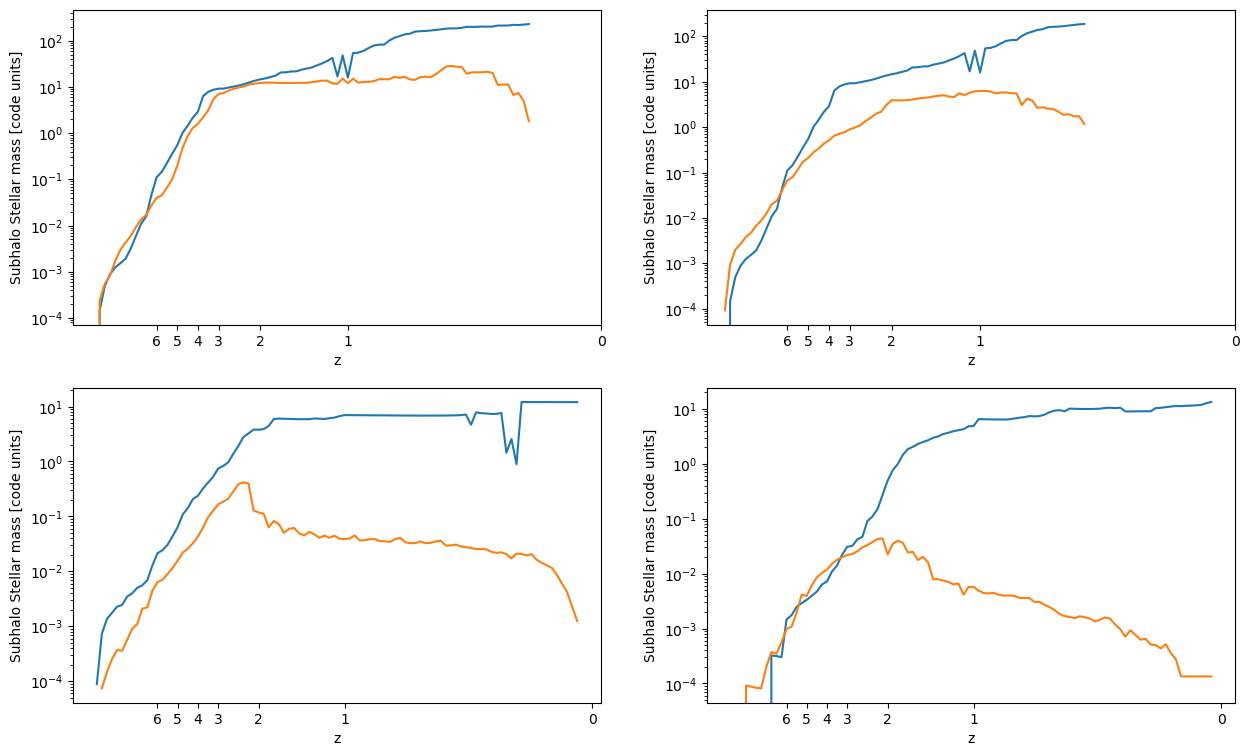

In [8]:
# Plot of the halo that had the most distant max past mass, as total subhalo mass


figure = plt.figure(figsize = (15,9))
ax = figure.subplots(nrows = 2, ncols = 2)

treeplot = il.sublink.loadTree(basePath,85,13057,fields=fields,onlyMPB=True)
treeplot2 = il.sublink.loadTree(basePath,85,13140,fields=fields,onlyMPB=True)
ax[0,0].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')
ax[0,0].plot(treeplot2['SnapNum'],treeplot2['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')

treeplot3 = il.sublink.loadTree(basePath,70,0,fields=fields,onlyMPB=True)
treeplot4 = il.sublink.loadTree(basePath,70,63,fields=fields,onlyMPB=True)

ax[0,1].plot(treeplot3['SnapNum'],treeplot3['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')
ax[0,1].plot(treeplot4['SnapNum'],treeplot4['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')

treeplot5 = il.sublink.loadTree(basePath,96,300653,fields=fields,onlyMPB=True)
treeplot6 = il.sublink.loadTree(basePath,96,301070,fields=fields,onlyMPB=True)
ax[1,0].plot(treeplot5['SnapNum'],treeplot5['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')
ax[1,0].plot(treeplot6['SnapNum'],treeplot6['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')

treeplot7 = il.sublink.loadTree(basePath,97,288765,fields=fields,onlyMPB=True)
treeplot8 = il.sublink.loadTree(basePath,97,289241,fields=fields,onlyMPB=True)
ax[1,1].plot(treeplot7['SnapNum'],treeplot7['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')
ax[1,1].plot(treeplot8['SnapNum'],treeplot8['SubhaloMassType'][:,il.util.partTypeNum('stars')],'-')

ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('z')
ax[0,0].set_ylabel('Subhalo Stellar mass [code units]')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('z')
ax[0,1].set_ylabel('Subhalo Stellar mass [code units]')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('z')
ax[1,0].set_ylabel('Subhalo Stellar mass [code units]')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('z')
ax[1,1].set_ylabel('Subhalo Stellar mass [code units]')

ax[0,0].set_xticks([99, 50, 33, 25, 21, 17, 13], [0, 1, 2, 3, 4, 5, 6])
ax[0,1].set_xticks([99, 50, 33, 25, 21, 17, 13], [0, 1, 2, 3, 4, 5, 6])
ax[1,0].set_xticks([99, 50, 33, 25, 21, 17, 13], [0, 1, 2, 3, 4, 5, 6])
ax[1,1].set_xticks([99, 50, 33, 25, 21, 17, 13], [0, 1, 2, 3, 4, 5, 6])

3255
3255
32550


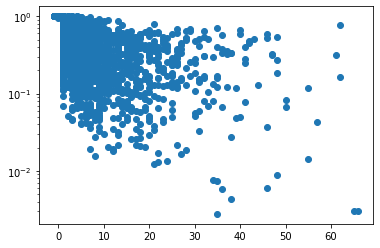

In [15]:
np_dM = (mass_ratios[:,2] - mass_ratios[:,4])/mass_ratios[:,2]
np_dM = mass_ratios[:,4]/mass_ratios[:,2]
# (MaxPastMass - mass now)/Max past mass

print(np.size(np_dM))
print(np.size(SnapDiff))
print(np.size(mass_ratios))

fp_dM = mass_ratios[:,3] - mass_ratios[:,5]

plt.scatter(SnapDiff, np_dM)
plt.yscale('log')

[10.26237819 10.07095745 10.51835222 ...  9.18997466  8.40115615
  9.12046189]


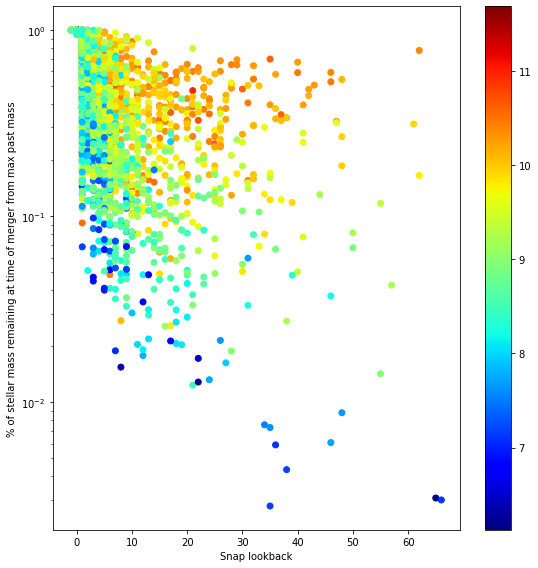

In [19]:
stellar_masses = np.log10(mass_ratios[:,4]) + 10
print(stellar_masses)

plt.figure(figsize = (8,8))
plt.scatter(SnapDiff, np_dM, c = (stellar_masses), cmap=plt.cm.jet)
plt.yscale('log')
plt.colorbar()
plt.xlabel('Snap lookback')
plt.ylabel('% of stellar mass remaining at time of merger from max past mass')
#plt.ylim(0.001,0.1)

plt.tight_layout()

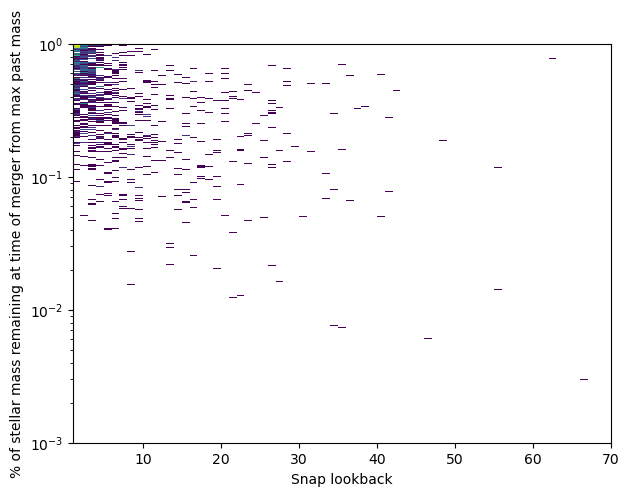

In [32]:
plt.hist2d(SnapDiff, np_dM, [np.linspace(1, 70, 70), np.logspace(-3, 0, 1001)], cmin = 1, cmax = 10)
plt.yscale('log')
#plt.colorbar()
plt.xlabel('Snap lookback')
plt.ylabel('% of stellar mass remaining at time of merger from max past mass')


plt.tight_layout()